# Proximity to Public Transit \& Housing Affordability

## Introduction


I am using the **Fannie Mae and Freddie Mac** data. I'm interested to look at the lending data as a proxy for housing sales, and to analyze either the effects of municipal permitting on housing markets on a MSA-to-MSA level, or look at how the ownership structure of housing differs between "high opportunity" and "low opportunity" areas.

## Data Loading

We start by loading libraries. For dataframes we are using `pandas`, for plots we are using `pyplot` from `matplotlib`.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Because the data is in ``.txt`` format, with no column headers, and is in many different files for different years and loan types, significant data cleaning is required. To begin, we set up short titles for each column based on the data dictionary provided, and then combine the Freddie and Fannie data into one dataframe for the year.

In [9]:
cols = ["flag","record_no","postal_code","msa_code","cty_code", "tract","pct_minority","median_inc_tract","ami","tract_inc_ratio","amfi","upb","purpose","seller_type","guarantee","lien_status","LTV","date","term_at_org","num_of_units","int_rate","note_amt","prop_val","pre_pen","balloon","interest_only","neg_amortization","other_nfaf","pct_affordable","construction_method","rural","LMDC","MAC","PPC","ACP","HOA","Colonias"]
freddie_2023 = pd.read_csv('data/fhlmc_mf2023c_loans.txt', sep=r'\s+', header=None, names = cols)
fannie_2023 = pd.read_csv('data/fnma_mf2023c_loans.txt', sep=r'\s+', header=None, names = cols)
mf_loans_2023 = pd.concat([freddie_2023, fannie_2023])

In addition, we want to have some dictionaries to decode data. For example, in the `loans` dataframe, each metropolitan area is given by its "MSA code", which means nothing to us. Rather, we want to know the MSA name.

In [10]:
msa_codes = pd.read_csv('data/MSA_2023.txt', sep='\s+=\s+', header=None, engine='python', names=['msa_code', 'msa_name'])
mf_loans_2023 = mf_loans_2023.merge(msa_codes, on='msa_code', how='left')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\emers\AppData\Local\Temp\ipykernel_65404\454297998.py:1: SyntaxWarning: invalid escape sequence '\s'
  msa_codes = pd.read_csv('data/MSA_2023.txt', sep='\s+=\s+', header=None, engine='python', names=['msa_code', 'msa_name'])


## Summary Statistics

One potentially interesting summary statistic is the quantity of loans in 2023 in each metropolitan area. We use ``groupby`` to look at each individual MSA and the count of entries in the table for each to define ``vol_by_msa`` which is the loan volume in each MSA.

In [11]:
vol_by_msa = mf_loans_2023.groupby('msa_name').size().sort_values(ascending=False)

In [6]:
mf_loans_2023[["pct_minority", "median_inc_tract", "LTV","num_of_units","note_amt","int_rate"]].describe()


,pct_minority,median_inc_tract,LTV,num_of_units,note_amt,int_rate
count,5468.000000,5468.000000,5468.000000,5468.000000,5.468000e+03,5468.000000
mean,53.414276,95970.101500,61.425642,3.818581,2.407242e+07,5.975040
std,26.730757,121930.260639,37.455017,1.901836,5.507027e+07,3.650544
min,4.770000,2499.000000,1.900000,1.000000,3.150000e+05,0.840000
25%,30.427500,53063.500000,54.467500,2.000000,4.222500e+06,5.340000
50%,50.790000,73061.000000,61.400000,4.000000,1.194000e+07,5.750000
75%,76.700000,101589.750000,65.600000,5.000000,3.052750e+07,6.270000
max,99.860000,999999.000000,999.000000,9.000000,1.000000e+09,99.000000


## Plots \& Figures

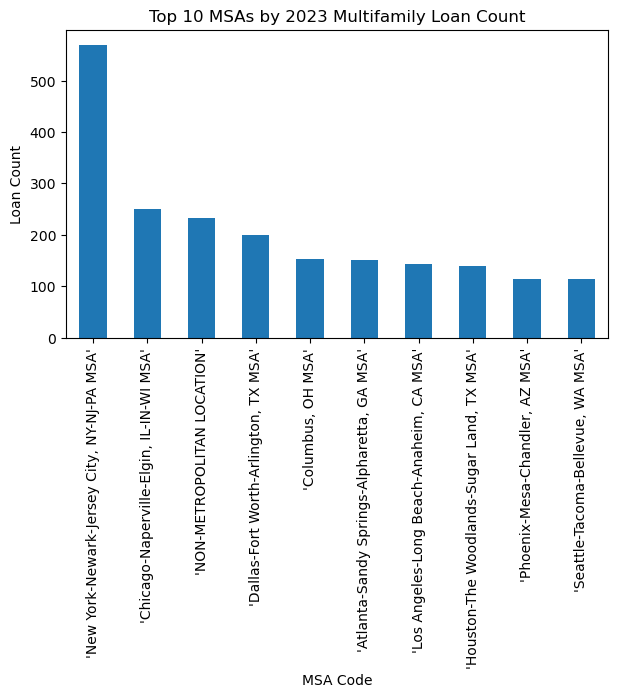

In [12]:
vol_by_msa.head(10).plot(kind='bar', figsize=(7, 4))
plt.title('Top 10 MSAs by 2023 Multifamily Loan Count')
plt.xlabel('MSA Code')
plt.ylabel('Loan Count')
plt.show()

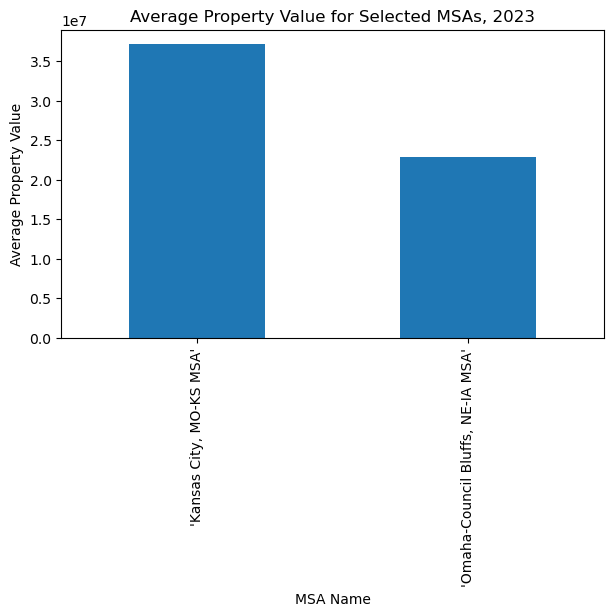

In [19]:
msa_filtered = mf_loans_2023[mf_loans_2023['msa_name'].isin(["'Omaha-Council Bluffs, NE-IA MSA'", "'Kansas City, MO-KS MSA'"])]
msa_filtered.groupby('msa_name')["prop_val"].mean().sort_values(ascending=False).plot(kind='bar', figsize=(7, 4))
plt.title('Average Property Value for Selected MSAs, 2023')
plt.xlabel('MSA Name')
plt.ylabel('Average Property Value')
plt.show()

## Conclusion